# Autoencoder Anomaly Detection
Prototype an anomaly detection algorithm using autoencoders. Will be using fashion-MNIST data set. "Hands-On Machine Learning", by Aurelien Geron, is the basis for much of the code. https://github.com/ageron/handson-ml2

In [14]:
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorboard

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

%matplotlib inline

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


## 1.0 Load and Prepare Data

In [2]:
# load fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(X_train_all, y_train_all), (X_test, y_test) = fashion_mnist.load_data()

# convert all to dtype float32
X_train_all = X_train_all.astype('float32')
X_test = X_test.astype('float32')

In [3]:
# class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
# split the data between train and validation sets, and scale
# also have a "slimmed down" data set that has only positive classes that will be used to train the autoencoder
X_val, X_val_slim, X_train_slim = X_train_all[:5000] / 255.0, \
                                        X_train_all[5000:10000] / 255.0, \
                                        X_train_all[10000:] / 255.0
y_val, y_val_slim, y_train_slim = y_train_all[:5000],y_train_all[5000:10000], y_train_all[10000:]

# also scale the X_test
X_test = X_test / 255.0

print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_val_slim shape:', X_val_slim.shape)
print('y_val_slim shape:', y_val_slim.shape)
print('X_train_slim shape:', X_train_slim.shape)
print('y_train_slim shape:', y_train_slim.shape)

X_val shape: (5000, 28, 28)
y_val shape: (5000,)
X_val_slim shape: (5000, 28, 28)
y_val_slim shape: (5000,)
X_train_slim shape: (50000, 28, 28)
y_train_slim shape: (50000,)


In [5]:
def remove_classes(class_to_remove, y_val_slim, X_val_slim):
    """Funciton to remove classes from train/val set"""
    
    # start with y_valid_slim
    index_to_delete = []
    for i, class_digit in enumerate(y_val_slim):
        if class_digit in class_to_remove:
            index_to_delete.append(i)

    y_val_slim = np.delete(y_val_slim, index_to_delete)
    X_val_slim = np.delete(X_val_slim, index_to_delete, axis=0)
    
    return X_val_slim, y_val_slim

In [6]:
# we will be training the autoencoder on the "normal" class only. All the rest will be labeled as "anomalous"
# this is how anomaly detection is done in Chalapathy R, 2019 https://arxiv.org/pdf/1802.06360.pdf
# I assume this is a good way to do it.... at least I can compare my results to theirs
class_normal = 0
class_to_remove = [i for i in range(0,10)]
class_to_remove.remove(class_normal)
class_to_remove = np.array(class_to_remove,dtype='uint8')


X_val_slim, y_val_slim = remove_classes(class_to_remove, y_val_slim, X_val_slim)
X_train_slim, y_train_slim = remove_classes(class_to_remove, y_train_slim, X_train_slim)

print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_val_slim shape:', X_val_slim.shape)
print('y_val_slim shape:', y_val_slim.shape)
print('X_train_slim shape:', X_train_slim.shape)
print('y_train_slim shape:', y_train_slim.shape)

X_val shape: (5000, 28, 28)
y_val shape: (5000,)
X_val_slim shape: (485, 28, 28)
y_val_slim shape: (485,)
X_train_slim shape: (5058, 28, 28)
y_train_slim shape: (5058,)


## 2.0 Sparse Autoencoder

We will build as sparse autoencoder. But first, we will build a vanilla stacked autoencoder as a comparison.

Andrew Ng has a good video of what a sparse autoencoder is: https://youtu.be/vfnxKO2rMq4

In [7]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Note: we are using sigmoid activations so that the activations all end up between 0 and 1. This will make visualizing the activations easier.

In [8]:
# plot the results
def plot_reconstructions(model, index_list, X_valid): 
    reconstructions = model.predict(X_valid)
    
    # get the length of index_list to set number of
    # images to plot
    n_images = len(index_list)

    # Plot a random sample
    fig, axes = plt.subplots(2, n_images,figsize=(n_images*1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    for i in range(0, n_images):
        axes[0][i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[0][i].axis('off')
        axes[0][i].set_title(str(index_list[i]))
        axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[1][i].axis('off')
        
    plt.show()

We want to see how the activations behave with this simple stacked autoencoder.
- Using the validation data set, **what is the distribution of activations between 0 and 1?**
- Using the validation data set, **what are the average neuron activation values?**

In [9]:
# build custom regularizer for KL-Divergence
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(),
              metrics=[rounded_accuracy])

# log_dir="logs/" + str('anom_') + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0,
#                                                       update_freq='epoch',profile_batch=0)

sparse_kl_encoder.summary()
sparse_kl_decoder.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               30300     
Total params: 108,800
Trainable params: 108,800
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
____________________________

In [11]:
# use tensorboard to track training
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=0,
                                                      update_freq='epoch',
                                                      profile_batch=0)

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                      patience=4, 
                                                      restore_best_weights=True)

history = sparse_kl_ae.fit(X_train_slim, X_train_slim, epochs=5,
                           validation_data=[X_val_slim, X_val_slim], callbacks=[])

Train on 5058 samples, validate on 485 samples
Epoch 1/5
5058/5058 [==============================] - 2s 312us/sample - loss: 0.4361 - rounded_accuracy: 0.8386 - val_loss: 0.3867 - val_rounded_accuracy: 0.8636
Epoch 2/5
5058/5058 [==============================] - 0s 93us/sample - loss: 0.3744 - rounded_accuracy: 0.8920 - val_loss: 0.3748 - val_rounded_accuracy: 0.8846
Epoch 3/5
5058/5058 [==============================] - 0s 92us/sample - loss: 0.3658 - rounded_accuracy: 0.8987 - val_loss: 0.3613 - val_rounded_accuracy: 0.9012
Epoch 4/5
5058/5058 [==============================] - 0s 92us/sample - loss: 0.3574 - rounded_accuracy: 0.9048 - val_loss: 0.3645 - val_rounded_accuracy: 0.8906
Epoch 5/5
5058/5058 [==============================] - 0s 92us/sample - loss: 0.3553 - rounded_accuracy: 0.9057 - val_loss: 0.3478 - val_rounded_accuracy: 0.9067


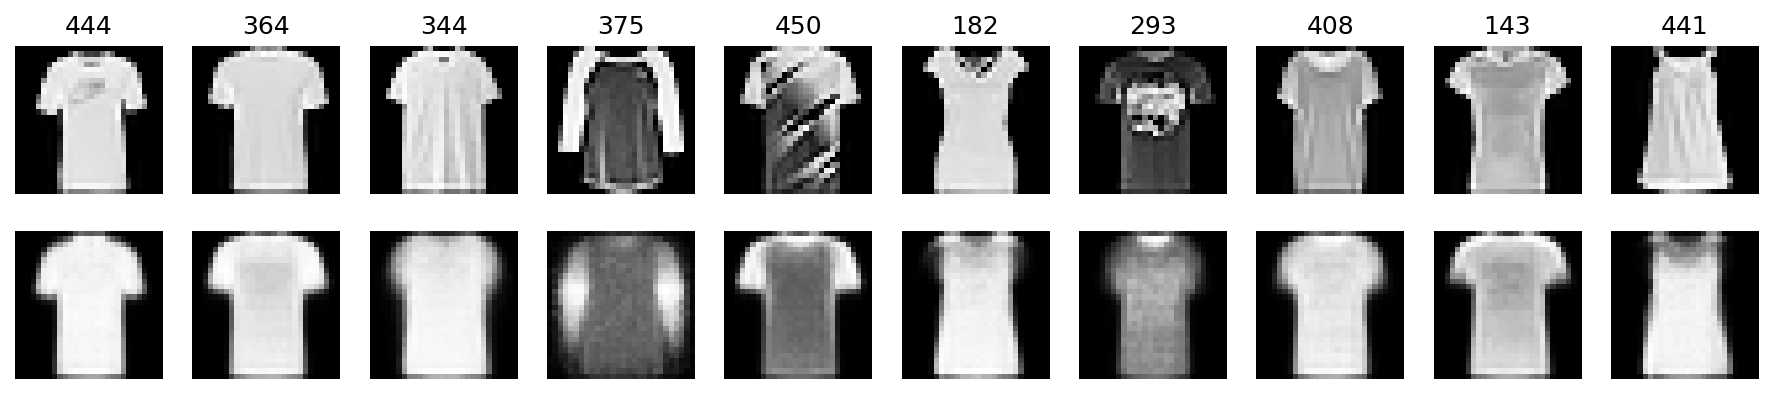

In [12]:
# plot a random number of items
import random
index_list = random.sample(range(0,len(X_val_slim)), 10)

plot_reconstructions(sparse_kl_ae, index_list, X_val_slim)

In [64]:
recon_val_slim = sparse_kl_ae(X_val_slim).numpy()
recon_val_slim.shape

(485, 28, 28)

In [139]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# build a table with all the RMSE results from the reconstructions
# sewar is a package that has many image quality assement algos already developed,
# and it can be used as a good guide https://github.com/andrewekhalel/sewar
# However, we will calculate the RMSE across the whole numpy array and then
# put these in a pandas dataframe

def mse(X_val,recon_val):
    """Calculate MSE for images in X_val and recon_val"""
    
    # need to calculate mean across the rows, and then across the columns
    return np.mean(np.mean(np.square(X_val.astype('float32') - recon_val.astype('float32')),axis=1),axis=1)

def rmse(X_val,recon_val):
    """Calculate RMSE for images in X_val and recon_val"""
    return np.sqrt(mse(X_val, recon_val))

def euclidean_distance(X_val,recon_val):
    dist = np.linalg.norm(X_val - recon_val,axis=(1,2))
    return dist

# function that creates a pandas dataframe with the RMSE value, and the associated class
def create_df_reconstruction(rmse_val, y_val, metric, class_to_remove, threshold_val):
    df = pd.DataFrame(data=rmse_val, columns=[metric])
    
    # append the class values
    df['class'] = y_val
    
    # label anomolous (outlier) data as -1, inliers as 1
        # -1 (outlier) is POSITIVE class
        #  1 (inlier) is NEGATIVE class
    new_y_val = []
    for i in y_val:
        if i in class_to_remove:
            new_y_val.append(-1)
        else:
            new_y_val.append(1)
    
    df['true_class'] = new_y_val
    
    # add prediction based on threshold
    df['prediction'] = np.where(df[metric] >= threshold_val,-1,1)
    
    return df

def threshold_grid_search(lower_bound, upper_bound, y_val, class_to_remove, method_recon_val):
    '''Simple grid search for finding the best threshold'''
    
    roc_scores = {}
    for i in np.arange(lower_bound, upper_bound, (np.abs(upper_bound-lower_bound) / 10)):
        print(i)
        
        threshold_val = i
        df = create_df_reconstruction(method_recon_val, y_val, "recon_metric",class_to_remove, threshold_val)
        roc_val = roc_auc_score(df['true_class'], df['prediction'])
        roc_scores[i] = roc_val

    # return best roc_score and the threshold used to set it
    threshold_val = max(zip(roc_scores.values(), roc_scores.keys()))
    print('Best threshold value:', threshold_val[1],'\tROC score: {:.2%}'.format(threshold_val[0]))

    # use the best threshold value to make a confusion matrix
    df_results = create_df_reconstruction(method_recon_val, y_val, "recon_metric",class_to_remove, threshold_val[1])
    
    print('\nConfusion Matrix:')
    print(confusion_matrix(df['true_class'], df['prediction']))
    
    fig, ax = plt.subplots(figsize=(10,8))
    df.boxplot(column=['recon_metric'], by='class', ax=ax).axhline(y=threshold_val[1],c='red',alpha=0.7)
    plt.title('Boxplots of MSE for X_valid, by Class')
    plt.suptitle('')
    plt.show()

        
# function to test the different reconstruction methods (mse, rmse, euclidean)
# do a grid search looking for the best threshold, and then outputting the results
def compare_select_method(model, X_val, y_val, X_val_slim, y_val_slim, class_to_remove):
    '''Function to test the different reconstruction methods (mse, rmse, euclidean) 
    
    Parameters
    ===========
    model : tensorflow model
        autoencoder model that was trained on the "slim" data set.
        Will be used to build reconstructions
    
    X_val : ndarray
        tensor of the X validation set
        
    class_to_remove : ndarray
        numpy array of the classes to remove from the X_val and y_val data
    '''
    
    # build the reconstructions on the X_val_slim dataset, and the X_val dataset
    recon_val_slim = model(X_val_slim).numpy()
    recon_val = model(X_val).numpy()
        
    # run through each of the reconstruction error methods, perform a little grid search
    # to find the optimum value
    
    #_______MSE_______#
    # calculate MSE reconstruction error
    mse_recon_val_slim = mse(X_val_slim, recon_val_slim) # for slim dataset
    mse_recon_val = mse(X_val, recon_val) # for complete validation dataset
    print('Max MSE on val_slim:\t\t\t',np.max(mse_recon_val_slim))
    print('90th MSE percentile on val_slim:\t', np.percentile(mse_recon_val_slim,90))
    
    lower_bound = 0
    upper_bound = 0.09
    
    df_results = threshold_grid_search(lower_bound,
                          upper_bound, 
                          y_val, 
                          class_to_remove, 
                          mse_recon_val) 
    return df_results

In [40]:
class SelectModel:
    
    def __init__(self, model, X_val, y_val, X_val_slim, class_to_remove):
        
        self.model = model
        self.X_val = X_val
        self.y_val = y_val
        self.X_val_slim = X_val_slim
        self.class_to_remove = class_to_remove
        
        print(np.shape(self.X_val))
        
        # build the reconstructions on the X_val_slim dataset, and the X_val dataset
        self.recon_val_slim = self.model(self.X_val_slim).numpy()
        self.recon_val = self.model(self.X_val).numpy()
        
    def mse(self):
        """Calculate MSE for images in X_val and recon_val"""
        # need to calculate mean across the rows, and then across the columns
        return np.mean(np.mean(np.square(self.X_val - self.recon_val),axis=1),axis=1)

    def rmse(self):
        """Calculate RMSE for images in X_val and recon_val"""
        return np.sqrt(self.mse(self.X_val, self.recon_val))

    def euclidean_distance(self):
        dist = np.linalg.norm(self.X_val - self.recon_val,axis=(1,2))
        return dist
    
    # function that creates a pandas dataframe with the RMSE value, and the associated class
    def create_df_reconstruction(self, reconstruction_error_val, threshold_val):
        df = pd.DataFrame(data=reconstruction_error_val, columns=["metric"])

        # append the class values
        df['class'] = self.y_val

        # label anomolous (outlier) data as -1, inliers as 1
            # -1 (outlier) is POSITIVE class
            #  1 (inlier) is NEGATIVE class
        new_y_val = []
        for i in self.y_val:
            if i in class_to_remove:
                new_y_val.append(-1)
            else:
                new_y_val.append(1)

        df['true_class'] = new_y_val

        # add prediction based on threshold
        df['prediction'] = np.where(df['metric'] >= threshold_val,-1,1)

        return df
    
    def threshold_grid_search(self, lower_bound, upper_bound, reconstruction_error_val):
        '''Simple grid search for finding the best threshold'''
    
        roc_scores = {}
        for i in np.arange(lower_bound, upper_bound, (np.abs(upper_bound-lower_bound) / 10)):
            print(i)

            threshold_val = i
            df = self.create_df_reconstruction(reconstruction_error_val, 
                                          threshold_val)
            roc_val = roc_auc_score(df['true_class'], df['prediction'])
            roc_scores[i] = roc_val

        # return best roc_score and the threshold used to set it
        threshold_val = max(zip(roc_scores.values(), roc_scores.keys()))
        print('Best threshold value:', threshold_val[1],'\tROC score: {:.2%}'.format(threshold_val[0]))

        # use the best threshold value to make a confusion matrix
        df = self.create_df_reconstruction(reconstruction_error_val, threshold_val[1])

        print('\nConfusion Matrix:')
        print(confusion_matrix(df['true_class'], df['prediction']))

        fig, ax = plt.subplots(figsize=(10,8))
        df.boxplot(column=['metric'], by='class', ax=ax).axhline(y=threshold_val[1],c='red',alpha=0.7)
        plt.title('Boxplots of MSE for X_valid, by Class')
        plt.suptitle('')
        plt.show()
        return df
        
    # function to test the different reconstruction methods (mse, rmse, euclidean)
    # do a grid search looking for the best threshold, and then outputting the results
    def compare_select_method(self):
        '''Function to test the different reconstruction methods (mse, rmse, euclidean) 

        Parameters
        ===========
        model : tensorflow model
            autoencoder model that was trained on the "slim" data set.
            Will be used to build reconstructions

        X_val : ndarray
            tensor of the X validation set

        class_to_remove : ndarray
            numpy array of the classes to remove from the X_val and y_val data
        '''

        # build the reconstructions on the X_val_slim dataset, and the X_val dataset
        recon_val_slim = self.model(self.X_val_slim).numpy()
        recon_val = self.model(self.X_val).numpy()

        # run through each of the reconstruction error methods, perform a little grid search
        # to find the optimum value

        #_______MSE_______#
        # calculate MSE reconstruction error
        mse_recon_val_slim = self.mse() # for slim dataset
        mse_recon_val = self.mse() # for complete validation dataset
        print('Max MSE on val_slim:\t\t\t',np.max(mse_recon_val_slim))
        print('90th MSE percentile on val_slim:\t', np.percentile(mse_recon_val_slim,90))

        lower_bound = 0
        upper_bound = 0.09

        df_results = self.threshold_grid_search(lower_bound,
                              upper_bound, 
                              mse_recon_val) 
        print(df_results.head())
        
        return df_results

In [45]:
model = SelectModel(sparse_kl_ae, X_val, y_val, X_val_slim, class_to_remove)

(5000, 28, 28)


Max MSE on val_slim:			 0.1884192
90th MSE percentile on val_slim:	 0.09944934621453286
0.0
0.009
0.018
0.026999999999999996
0.036
0.045
0.05399999999999999
0.063
0.072
0.08099999999999999
Best threshold value: 0.026999999999999996 	ROC score: 82.58%

Confusion Matrix:
[[3915  628]
 [  96  361]]


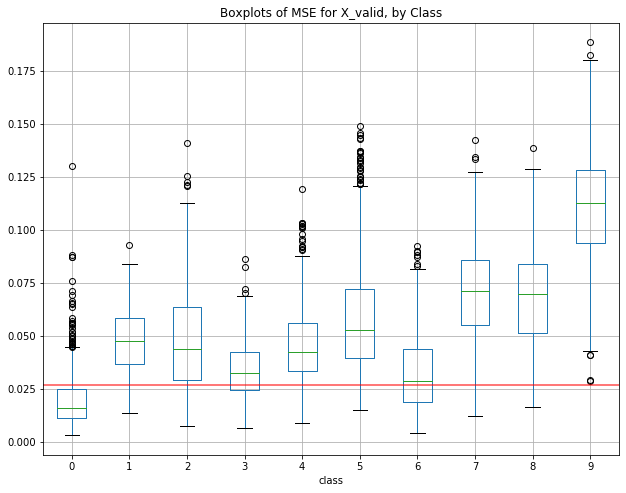

     metric  class  true_class  prediction
0  0.115440      9          -1          -1
1  0.026221      0           1           1
2  0.010559      0           1           1
3  0.018203      3          -1           1
4  0.030204      0           1          -1


In [46]:
df = model.compare_select_method()

In [43]:
df.head()

,metric,class,true_class,prediction
0,0.115440,9,-1,-1
1,0.026221,0,1,1
2,0.010559,0,1,1
3,0.018203,3,-1,1
4,0.030204,0,1,-1


Max MSE on val_slim:			 0.096097164
90th MSE percentile on val_slim:	 0.03584753125905991
0.0
0.009
0.018
0.026999999999999996
0.036
0.045
0.05399999999999999
0.063
0.072
0.08099999999999999
Best threshold value: 0.0 	ROC score: 50.00%

Confusion Matrix:
[[  57  904]
 [ 872 3167]]


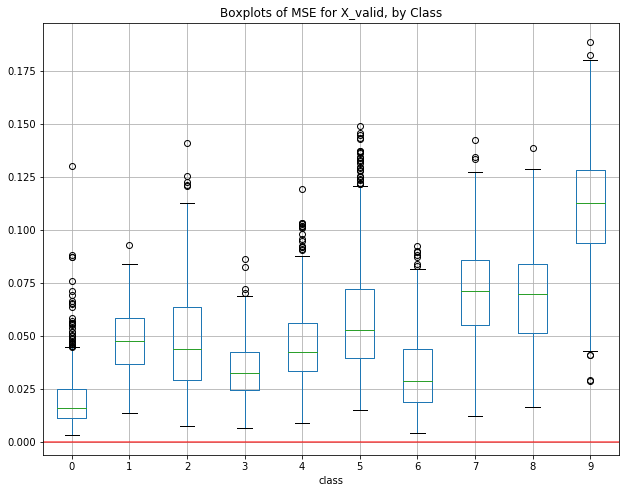

In [140]:
df_results = compare_select_method(sparse_kl_ae, X_val, y_val, X_val_slim, y_val_slim, class_to_remove)

In [138]:
df_results.head()

,recon_metric,class,true_class,prediction
0,0.115437,9,1,-1
1,0.026222,0,-1,-1
2,0.010560,0,-1,-1
3,0.018204,3,1,-1
4,0.030204,0,-1,-1


In [142]:
# get the reconstructions on the X_val_slim dataset, and the X_val dataset
recon_val_slim = sparse_kl_ae(X_val_slim).numpy()
recon_val = sparse_kl_ae(X_val).numpy()

# calculate MSE reconstruction error
mse_recon_val_slim = mse(X_val_slim, recon_val_slim) # for slim dataset
mse_recon_val = mse(X_val, recon_val) # for complete validation dataset

# look at the maximum reconstruction error, and the 90th percentile
print(np.max(mse_recon_val_slim))
print(np.percentile(mse_recon_val_slim,90))

0.096097164
0.03584753125905991


Best threshold value: 0.2 	ROC score: 50.00%

True Positive: 0
False Positive: 0
True Negative: 4039
False Negative: 961

Confusion Matrix:
[[   0  961]
 [   0 4039]]


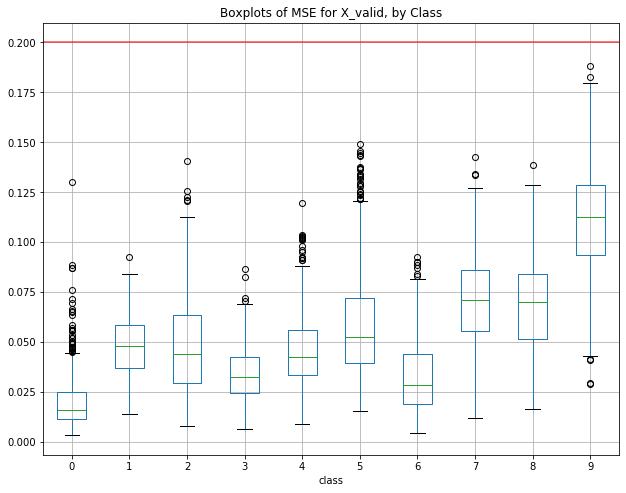

In [143]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

roc_scores = {}
# for i in np.arange(0.1, 150, 0.5):
for i in np.arange(0.0001, 0.2, 0.0001):
     
    threshold_val = i
    df = create_df_reconstruction(mse_recon_val, y_val, "recon_metric",class_to_remove, threshold_val)
    roc_val = roc_auc_score(df['true_class'], df['prediction'])
    roc_scores[i] = roc_val

# return best roc_score and the threshold used to set it
threshold_val_mse = max(zip(roc_scores.values(), roc_scores.keys()))
print('Best threshold value:', threshold_val_mse[1],'\tROC score: {:.2%}'.format(threshold_val_mse[0]))

# use the best threshold value to make a confusion matrix
df = create_df_reconstruction(mse_recon_val, y_val, "recon_metric",class_to_remove, threshold_val_mse[1])


# True Positive
print("\nTrue Positive:",len(df[(df['true_class']==-1) & (df['prediction']==-1)]))
# False Positive -- predict anomaly (-1), when it is actually normal (1)
print("False Positive:",len(df[(df['true_class']==1) & (df['prediction']==-1)]))
# True Negative
print("True Negative:",len(df[(df['true_class']==1) & (df['prediction']==1)]))
#False Negative
print("False Negative:",len(df[(df['true_class']==-1) & (df['prediction']==1)]))

print('\nConfusion Matrix:')
print(confusion_matrix(df['true_class'], df['prediction']))

fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['recon_metric'], by='class', ax=ax).axhline(y=threshold_val_mse[1],c='red',alpha=0.7)
plt.title('Boxplots of MSE for X_valid, by Class')
plt.suptitle('')
plt.show()

In [144]:
df

,recon_metric,class,true_class,prediction
0,0.115437,9,1,1
1,0.026222,0,-1,1
2,0.010560,0,-1,1
3,0.018204,3,1,1
4,0.030204,0,-1,1
...,...,...,...,...
4995,0.087705,7,1,1
4996,0.035804,6,1,1
4997,0.041211,5,1,1
4998,0.090357,8,1,1


In [147]:
df1=create_df_reconstruction(mse_recon_val, y_val, 'rmse', class_to_remove, 0.1)

In [148]:
df1

,rmse,class,true_class,prediction
0,0.115437,9,-1,-1
1,0.026222,0,1,1
2,0.010560,0,1,1
3,0.018204,3,-1,1
4,0.030204,0,1,1
...,...,...,...,...
4995,0.087705,7,-1,1
4996,0.035804,6,-1,1
4997,0.041211,5,-1,1
4998,0.090357,8,-1,1


In [149]:
confusion_matrix(df1['true_class'], df1['prediction'])

array([[ 488, 4055],
       [   1,  456]])

In [150]:
roc_auc_score(df1['true_class'], df1['prediction'])

0.5526149109578253

In [76]:
# euclidean distance measurements
eu_val_slim = euclidean_distance(X_val_slim,recon_val_slim)

In [77]:
np.where(eu_val_slim > 3.99, 1,0)

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,

In [78]:
print(np.max(eu_val_slim))
print(np.percentile(eu_val_slim,90))

8.679872
5.301364135742188


In [79]:
df = create_df_reconstruction(eu_val_slim, y_val_slim, "euclidean",class_to_remove, 3.99)
df.head()

,euclidean,class,true_class,prediction
0,3.325459,0,-1,1
1,5.730689,0,-1,-1
2,2.760932,0,-1,1
3,1.912342,0,-1,1
4,2.795930,0,-1,1


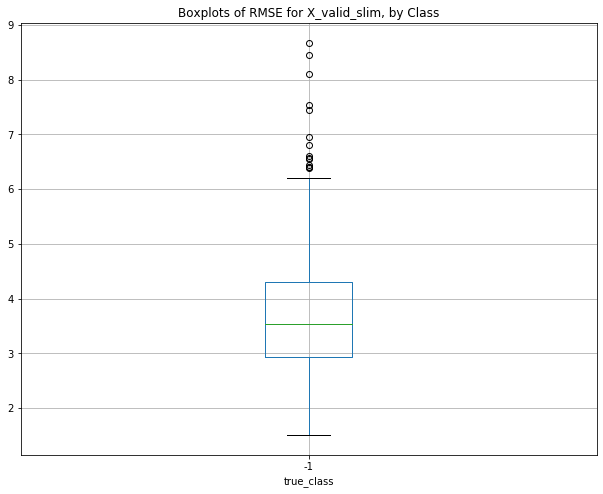

In [81]:
fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['euclidean'], by='true_class', ax=ax)
plt.title('Boxplots of RMSE for X_valid_slim, by Class')
plt.suptitle('')
plt.show()

In [82]:
recon_val = sparse_kl_ae(X_val).numpy()
recon_val.shape

eu_val = euclidean_distance(X_val,recon_val)
eu_val

df = create_df_reconstruction(eu_val, y_val, "euclidean",class_to_remove, 3.99)
df[0:20]

,euclidean,class,true_class,prediction
0,9.513305,9,1,-1
1,4.534059,0,-1,-1
2,2.877383,0,-1,1
3,3.777819,3,1,1
4,4.866239,0,-1,-1
5,7.156709,2,-1,-1
6,7.896404,7,1,-1
7,8.219693,2,-1,-1
8,6.233595,5,1,-1
9,9.923738,5,1,-1


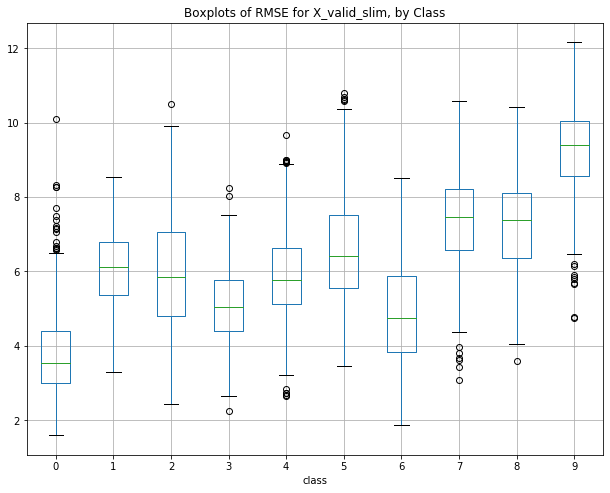

In [83]:
fig, ax = plt.subplots(figsize=(10,8))
df.boxplot(column=['euclidean'], by='class', ax=ax)
plt.title('Boxplots of RMSE for X_valid_slim, by Class')
plt.suptitle('')
plt.show()